# Week 3 Activity 1: Phase 1 - Foundations & Diagnostics

## Learning Objectives

By the end of this notebook, you will understand:

1. **Why test before batch processing** - The importance of validating your approach on a single example
2. **How polygon size constrains patch size** - The relationship between training data geometry and CNN input dimensions
3. **How to extract patches from Earth Engine** - The mechanics of converting satellite imagery to NumPy arrays
4. **How to determine optimal parameters** - Balancing spatial context with polygon constraints

## What is Phase 1?

Phase 1 is about **validation and configuration** before attempting batch extraction. We will:

- Load and analyze our training polygons to understand size constraints
- Verify access to our Sentinel-2 composite imagery
- **Test extraction on a single patch** (the critical diagnostic!)
- Determine optimal patch size and extraction parameters

**The key insight:** If single-patch extraction fails, batch extraction will also fail. Better to catch issues now!

---

## Section 1: Setup & Configuration

We'll start by importing the necessary packages and initializing Earth Engine.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Initialize Earth Engine
ee.Initialize()

print("✓ Packages imported")
print("✓ Earth Engine initialized")

✓ Packages imported
✓ Earth Engine initialized


In [2]:
# Define paths
REPO = Path.cwd().parent  # Repository root (assumes running from notebooks/)
DATA = REPO / 'data'
POLYGONS_FILE = DATA / 'labels' / 'larger_polygons.geojson'
AOI_FILE = DATA / 'external' / 'larger_aoi.geojson'

# Configuration
BANDS = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']  # Blue, Green, Red, NIR, SWIR1, SWIR2
ASSET_ID = 'users/markstonegobigred/Parcela/s2_2019_median_6b'  # Pre-built Sentinel-2 composite

print(f"Data directory: {DATA}")
print(f"Polygons file: {POLYGONS_FILE.name}")
print(f"Bands: {BANDS}")

Data directory: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data
Polygons file: larger_polygons.geojson
Bands: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']


---

## Section 2: Load & Analyze Training Polygons

### Why polygon size matters

**The fundamental constraint:** Patches must fit **inside** training polygons.

If your smallest polygon is 100m × 100m, you can't extract 200m × 200m patches from it!

**Key concept:** The **smallest class** (by median area) determines the maximum patch size we can use.

Let's load our polygons and calculate their sizes.

In [3]:
# Load polygons and ensure WGS84 (required for Earth Engine)
polygons = gpd.read_file(POLYGONS_FILE)
if polygons.crs.to_string() != 'EPSG:4326':
    polygons = polygons.to_crs('EPSG:4326')

print(f"Loaded {len(polygons)} training polygons")
print(f"Classes: {sorted(polygons['class_name'].unique())}")

Loaded 126 training polygons
Classes: ['Agriculture', 'Forest', 'Parcels', 'Urban', 'Water']


In [4]:
# Calculate areas in hectares
# Convert to UTM (EPSG:32718 = UTM Zone 18S for Chile) for accurate metric measurements
polygons_utm = polygons.to_crs('EPSG:32718')
polygons['area_ha'] = polygons_utm.geometry.area / 10000  # m² to hectares

# Compute per-class statistics
class_stats = polygons.groupby('class_name')['area_ha'].agg(['count', 'median', 'min', 'max']).round(2)

print("\nClass Statistics (hectares):")
print(class_stats)


Class Statistics (hectares):
             count  median   min    max
class_name                             
Agriculture     35    5.48  0.58  10.82
Forest          16    8.90  2.76  32.03
Parcels         32    8.08  3.11  37.27
Urban           29    2.14  0.65   6.51
Water           13    3.39  0.17  10.24


In [5]:
# Find smallest class (this will constrain our patch size)
smallest_class = class_stats['median'].idxmin()
smallest_median = class_stats.loc[smallest_class, 'median']
smallest_side_m = np.sqrt(smallest_median * 10000)  # Assume square polygon

print(f"\n🔍 Key Finding:")
print(f"   Smallest class: {smallest_class}")
print(f"   Median area: {smallest_median:.2f} ha")
print(f"   Approximate side: {smallest_side_m:.0f}m (~{int(smallest_side_m/10)} pixels at 10m resolution)")
print(f"\n   → This constrains our maximum patch size!")


🔍 Key Finding:
   Smallest class: Urban
   Median area: 2.14 ha
   Approximate side: 146m (~14 pixels at 10m resolution)

   → This constrains our maximum patch size!


### Visualize polygon size distribution

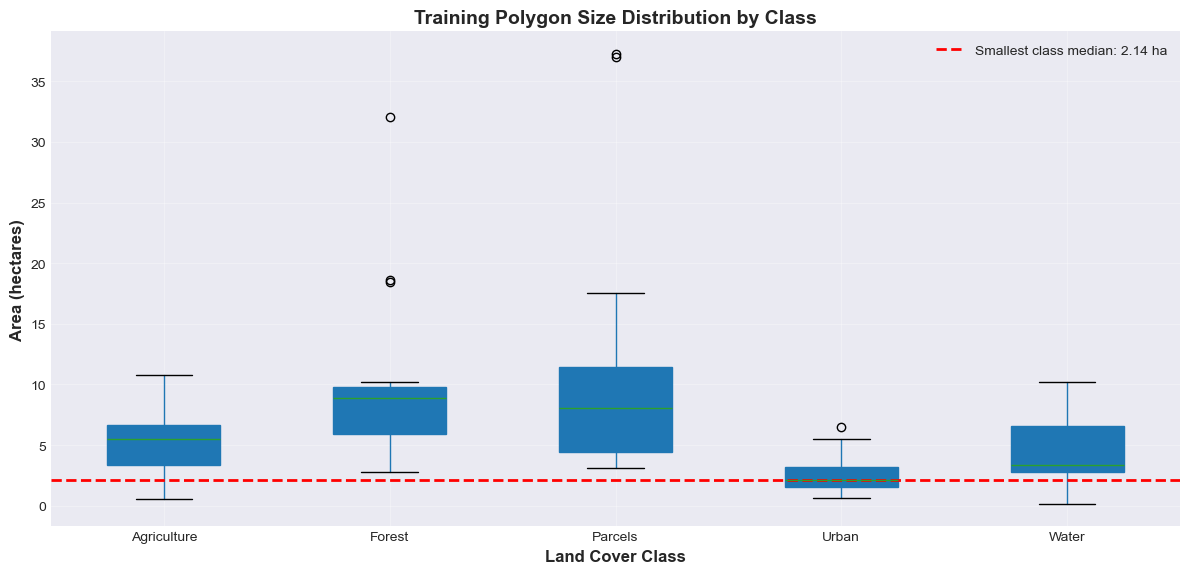


💡 Interpretation:
   Urban is the smallest class (red line shows median).
   Our patch size must be small enough to fit within these polygons.


In [6]:
# Create box plot by class
fig, ax = plt.subplots(figsize=(12, 6))

# Box plot
polygons.boxplot(column='area_ha', by='class_name', ax=ax, patch_artist=True)
ax.set_xlabel('Land Cover Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Area (hectares)', fontsize=12, fontweight='bold')
ax.set_title('Training Polygon Size Distribution by Class', fontsize=14, fontweight='bold')
ax.get_figure().suptitle('')  # Remove auto-generated title

# Add reference line for smallest class median
ax.axhline(smallest_median, color='red', linestyle='--', linewidth=2, 
           label=f'Smallest class median: {smallest_median:.2f} ha')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   {smallest_class} is the smallest class (red line shows median).")
print(f"   Our patch size must be small enough to fit within these polygons.")

---

## Section 3: Load Sentinel-2 Composite

### What is a composite?

A **composite** is a single image created by combining multiple satellite images over time. We use the **median** value for each pixel across all cloud-free observations.

**Why use composites?**
- Reduces cloud contamination
- Provides consistent imagery across large areas  
- Simplifies data processing (one image instead of many)

Our composite covers the 2018-2019 Austral growing season.

In [7]:
# Load pre-built composite from Earth Engine asset
composite = ee.Image(ASSET_ID).select(BANDS)

# Verify bands
band_list = composite.bandNames().getInfo()

print(f"✓ Composite loaded successfully")
print(f"  Asset ID: {ASSET_ID}")
print(f"  Bands: {band_list}")
print(f"  Resolution: 10m per pixel")

✓ Composite loaded successfully
  Asset ID: users/markstonegobigred/Parcela/s2_2019_median_6b
  Bands: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
  Resolution: 10m per pixel


### Band Information

Our 6-band configuration includes:

| Band | Name | Wavelength | Purpose |
|------|------|------------|----------|
| B2 | Blue | 490 nm | Water bodies, atmosphere |
| B3 | Green | 560 nm | Vegetation vigor |
| B4 | Red | 665 nm | Chlorophyll absorption |
| B8 | NIR | 842 nm | Vegetation biomass |
| B11 | SWIR1 | 1610 nm | Moisture content, burn scars |
| B12 | SWIR2 | 2190 nm | Soil/vegetation discrimination |

**Why these bands?** They provide complementary information about land cover:
- **Visible (B2, B3, B4):** What we see with our eyes
- **NIR (B8):** Healthy vegetation reflects strongly in NIR
- **SWIR (B11, B12):** Sensitive to water content and soil properties

---

## Section 4: Test Single Patch Extraction

### Why test on one patch first?

**This is the most critical step in Phase 1!**

Before extracting hundreds of patches, we need to verify:
1. ✅ Extraction works (no Earth Engine errors)
2. ✅ Patch dimensions are correct
3. ✅ No excessive missing data (NaN values)
4. ✅ Value ranges are reasonable
5. ✅ Visualization looks correct

**If this test fails, batch extraction will also fail.** Better to catch issues now!

### Select test polygon

We'll choose a polygon from the **smallest class** (most challenging) with median size.

In [8]:
# Select median-sized polygon from smallest class
test_polygons = polygons[polygons['class_name'] == smallest_class].copy()
test_polygons = test_polygons.sort_values('area_ha')
test_poly = test_polygons.iloc[len(test_polygons) // 2]  # Median

print(f"Test Polygon:")
print(f"  Class: {test_poly['class_name']}")
print(f"  Area: {test_poly['area_ha']:.2f} ha")
print(f"  ID: {test_poly.name}")

Test Polygon:
  Class: Urban
  Area: 2.14 ha
  ID: 83


### Extract patch

We'll extract an **8×8 pixel patch** (80m × 80m) centered on the polygon.

**Why 8×8?** 
- Small enough to fit in our smallest polygons
- Large enough for basic CNN spatial context
- We'll refine this in Section 5

In [9]:
# Get polygon centroid
centroid = test_poly.geometry.centroid
lat, lon = centroid.y, centroid.x

# Define patch size
PATCH_SIZE = 8  # pixels
patch_half = (PATCH_SIZE * 10) / 2  # half-width in meters (10m/pixel)

# Convert meters to degrees at this latitude
meters_per_deg_lat = 111320  # Approximately constant
meters_per_deg_lon = 111320 * np.cos(np.radians(lat))  # Varies with latitude

half_deg_lon = patch_half / meters_per_deg_lon
half_deg_lat = patch_half / meters_per_deg_lat

# Create patch bounding box
patch_geom = ee.Geometry.Rectangle([
    lon - half_deg_lon,
    lat - half_deg_lat,
    lon + half_deg_lon,
    lat + half_deg_lat
])

print(f"Patch bounds calculated:")
print(f"  Center: ({lon:.4f}, {lat:.4f})")
print(f"  Size: {PATCH_SIZE}×{PATCH_SIZE} pixels ({PATCH_SIZE*10}m × {PATCH_SIZE*10}m)")

Patch bounds calculated:
  Center: (-73.0334, -41.1380)
  Size: 8×8 pixels (80m × 80m)


In [10]:
# Extract patch from Earth Engine
print("Extracting patch from Earth Engine...")
print("(This may take 10-30 seconds)")

patch = geemap.ee_to_numpy(
    composite,
    region=patch_geom,
    scale=10,  # 10m resolution
    bands=BANDS
)

# Handle size mismatch (Earth Engine sometimes returns slightly different dimensions)
if patch.shape[:2] != (PATCH_SIZE, PATCH_SIZE):
    print(f"  Note: Resizing from {patch.shape} to ({PATCH_SIZE}, {PATCH_SIZE}, {len(BANDS)})")
    h, w, c = patch.shape
    resized = np.full((PATCH_SIZE, PATCH_SIZE, len(BANDS)), np.nan)
    h_copy = min(h, PATCH_SIZE)
    w_copy = min(w, PATCH_SIZE)
    resized[:h_copy, :w_copy, :] = patch[:h_copy, :w_copy, :]
    patch = resized

print(f"\n✓ Extraction successful!")
print(f"  Shape: {patch.shape}")

Extracting patch from Earth Engine...
(This may take 10-30 seconds)
  Note: Resizing from (9, 11, 6) to (8, 8, 6)

✓ Extraction successful!
  Shape: (8, 8, 6)


### Quality check

In [11]:
# Check for missing data
nan_pct = np.isnan(patch).sum() / patch.size * 100
valid = patch[~np.isnan(patch)]

print(f"Quality Metrics:")
print(f"  NaN pixels: {nan_pct:.1f}%")
print(f"  Value range: [{valid.min():.0f}, {valid.max():.0f}]")
print(f"  Mean: {valid.mean():.0f}")

# Interpret results
if nan_pct == 0:
    print("\n✓ Perfect! No missing data.")
elif nan_pct < 20:
    print(f"\n✓ Acceptable NaN percentage (<20%).")
else:
    print(f"\n⚠️  High NaN percentage! May indicate heavy cloud masking.")

if 0 <= valid.min() <= valid.max() <= 10000:
    print("✓ Value range is reasonable for Sentinel-2 surface reflectance.")
else:
    print("⚠️  Unusual value range - check composite quality.")

Quality Metrics:
  NaN pixels: 0.0%
  Value range: [276, 4276]
  Mean: 1495

✓ Perfect! No missing data.
✓ Value range is reasonable for Sentinel-2 surface reflectance.


### Visualize extracted patch

Let's create RGB and NIR visualizations to verify the patch looks correct.

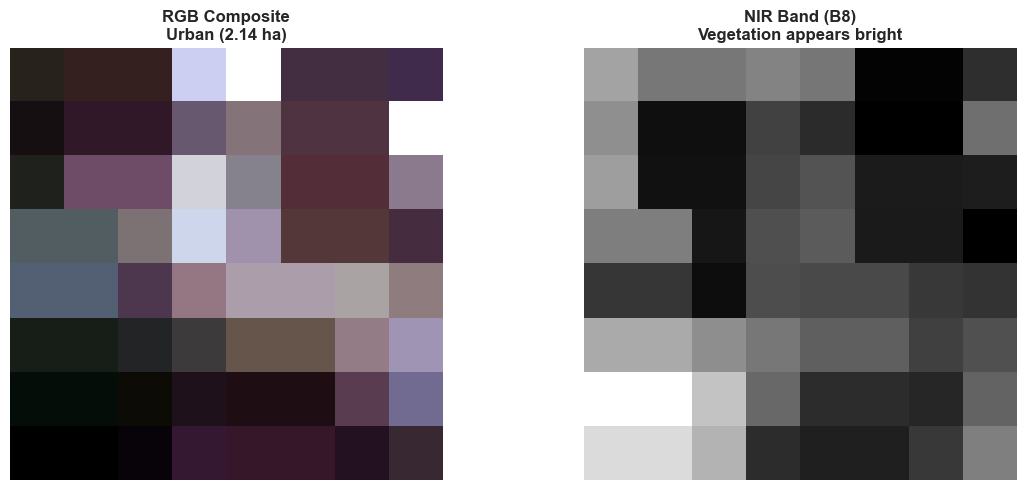


💡 What to look for:
   - RGB should show expected land cover type (Urban)
   - NOT completely black (= no data)
   - NOT completely white (= clouds/missing)
   - NIR: Healthy vegetation should appear bright


In [12]:
# Create RGB and NIR visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RGB (bands: R=B4, G=B3, B=B2)
rgb = patch[:, :, [2, 1, 0]]  # R, G, B indices in our band list

# Normalize using percentile stretch for better contrast
rgb_display = np.zeros_like(rgb)
for i in range(3):
    band = rgb[:, :, i]
    valid_band = band[~np.isnan(band)]
    if len(valid_band) > 0:
        p2 = np.percentile(valid_band, 2)
        p98 = np.percentile(valid_band, 98)
        band_norm = np.clip((band - p2) / (p98 - p2), 0, 1)
        band_norm[np.isnan(band)] = 0  # NaN to black
        rgb_display[:, :, i] = band_norm

axes[0].imshow(rgb_display)
axes[0].set_title(f'RGB Composite\n{test_poly["class_name"]} ({test_poly["area_ha"]:.2f} ha)', 
                  fontsize=12, fontweight='bold')
axes[0].axis('off')

# NIR (B8 - band index 3)
nir = patch[:, :, 3]
nir_display = nir.copy()
valid_nir = nir[~np.isnan(nir)]
if len(valid_nir) > 0:
    p2 = np.percentile(valid_nir, 2)
    p98 = np.percentile(valid_nir, 98)
    nir_display = np.clip((nir - p2) / (p98 - p2), 0, 1)
    nir_display[np.isnan(nir)] = 0

axes[1].imshow(nir_display, cmap='gray')
axes[1].set_title('NIR Band (B8)\nVegetation appears bright', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n💡 What to look for:")
print(f"   - RGB should show expected land cover type ({test_poly['class_name']})")
print(f"   - NOT completely black (= no data)")
print(f"   - NOT completely white (= clouds/missing)")
print(f"   - NIR: Healthy vegetation should appear bright")

### ✅ Critical Milestone

**If you see reasonable RGB and NIR images above, congratulations!**

This means:
- ✅ Earth Engine connection works
- ✅ Composite is accessible
- ✅ Patch extraction works
- ✅ Data quality is acceptable

**You're ready to proceed to batch extraction in Phase 2!**

---

## Section 5: Determine Optimal Patch Size

### The patch size trade-off

**Larger patches:**
- ✅ More spatial context for CNN
- ✅ Can capture landscape patterns
- ❌ May not fit in small polygons
- ❌ Fewer patches per polygon

**Smaller patches:**
- ✅ Fit in small polygons
- ✅ More patches per polygon
- ❌ Less spatial context
- ❌ May be too small for effective CNN learning

### Our approach

1. Calculate recommended patch size for each class (based on polygon size)
2. Choose the **minimum** across all classes (must work for smallest polygons)
3. Apply practical constraints (CNN minimum, computational efficiency)
4. Determine how many patches to extract per polygon

In [13]:
# Calculate recommended patch sizes per class
recommendations = {}

for class_name in class_stats.index:
    median_area_ha = class_stats.loc[class_name, 'median']
    median_area_m2 = median_area_ha * 10000
    
    # Assume square polygon: side = sqrt(area)
    side_m = np.sqrt(median_area_m2)
    
    # Patch should be ~1/4 of polygon side (leaves room for random jitter)
    recommended_m = side_m / 4
    recommended_px = int(recommended_m / 10)  # 10m resolution
    
    recommendations[class_name] = {
        'side_m': side_m,
        'recommended_px': recommended_px
    }

# Display recommendations
print("Recommended Patch Sizes by Class:")
print("-" * 50)
for class_name, rec in recommendations.items():
    print(f"{class_name:12s}: {rec['side_m']:5.0f}m side → {rec['recommended_px']:2d}px patch")

min_recommended = min([rec['recommended_px'] for rec in recommendations.values()])
print(f"\nMinimum recommended: {min_recommended}px")

Recommended Patch Sizes by Class:
--------------------------------------------------
Agriculture :   234m side →  5px patch
Forest      :   298m side →  7px patch
Parcels     :   284m side →  7px patch
Urban       :   146m side →  3px patch
Water       :   184m side →  4px patch

Minimum recommended: 3px


In [14]:
# Apply practical constraints
MIN_CNN_SIZE = 8  # Minimum patch size for meaningful CNN learning
MAX_PRACTICAL = 64  # Maximum for computational efficiency
PREFERRED_SIZES = [8, 12, 16, 20, 24, 32, 48, 64]  # Standard sizes

# Choose patch size
if min_recommended < MIN_CNN_SIZE:
    FINAL_PATCH_SIZE = MIN_CNN_SIZE
    reason = f"Minimum ({min_recommended}px) too small, using CNN minimum"
else:
    # Choose largest preferred size that doesn't exceed minimum
    valid = [p for p in PREFERRED_SIZES if p <= min_recommended]
    FINAL_PATCH_SIZE = max(valid) if valid else MIN_CNN_SIZE
    reason = f"Largest preferred size ≤ minimum ({min_recommended}px)"

print(f"\n📐 Final Patch Size Decision:")
print(f"   PATCH_SIZE = {FINAL_PATCH_SIZE} pixels ({FINAL_PATCH_SIZE * 10}m × {FINAL_PATCH_SIZE * 10}m)")
print(f"   Reason: {reason}")


📐 Final Patch Size Decision:
   PATCH_SIZE = 8 pixels (80m × 80m)
   Reason: Minimum (3px) too small, using CNN minimum


In [15]:
# Determine patches per polygon
patch_area_m2 = (FINAL_PATCH_SIZE * 10) ** 2

patches_per_polygon = {}
for class_name in class_stats.index:
    median_area_m2 = class_stats.loc[class_name, 'median'] * 10000
    theoretical_max = int(median_area_m2 / patch_area_m2)
    # Extract conservatively: 10-15% of theoretical max, min 1, max 20
    recommended = max(1, min(20, int(theoretical_max * 0.15)))
    patches_per_polygon[class_name] = recommended

# Use minimum across classes for consistency (or could use per-class values)
PATCHES_PER_POLYGON = max(3, min(patches_per_polygon.values()))

print(f"\n   PATCHES_PER_POLYGON = {PATCHES_PER_POLYGON}")
print(f"   Estimated total patches = {len(polygons) * PATCHES_PER_POLYGON}")


   PATCHES_PER_POLYGON = 3
   Estimated total patches = 378


### Visualize decision

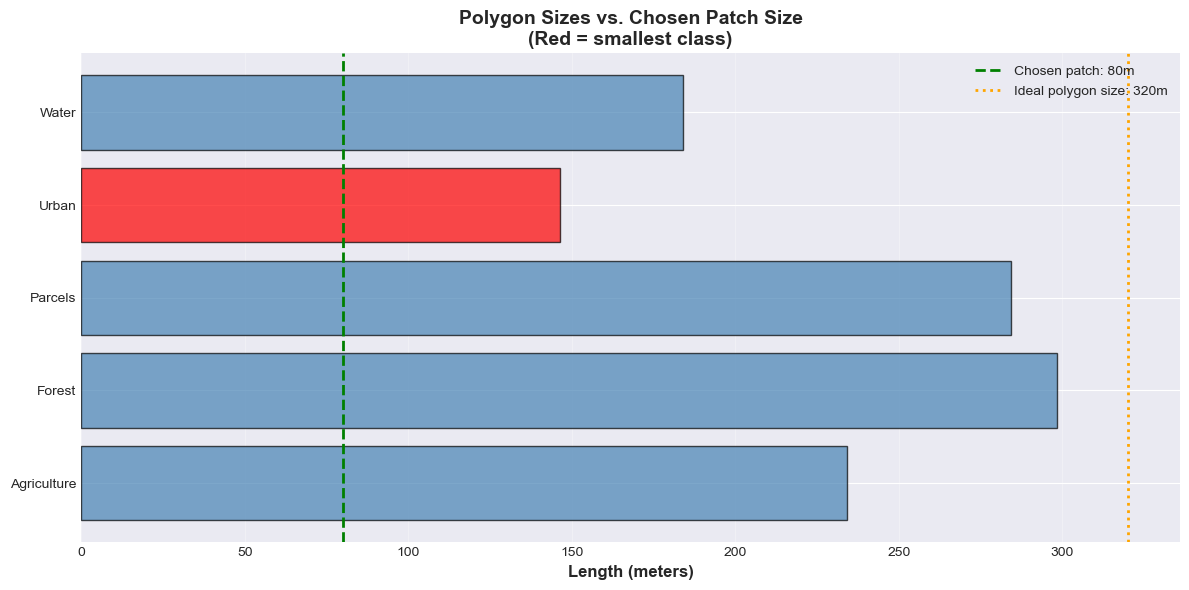


💡 Interpretation:
   Green line = chosen patch size (80m)
   Orange line = ideal polygon size (4× patch = 320m)
   All bars should extend well beyond the green line.
   Most bars should be near or beyond the orange line.


In [16]:
# Create visualization of polygon sizes vs chosen patch size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot polygon sides
class_names = [rec for rec in recommendations.keys()]
median_sides = [recommendations[c]['side_m'] for c in class_names]
colors = ['red' if c == smallest_class else 'steelblue' for c in class_names]

bars = ax.barh(class_names, median_sides, color=colors, alpha=0.7, edgecolor='black')

# Add chosen patch size line
patch_size_m = FINAL_PATCH_SIZE * 10
ax.axvline(patch_size_m, color='green', linestyle='--', linewidth=2, 
           label=f'Chosen patch: {patch_size_m}m')

# Add 4× patch line (polygon should be ~4× patch size)
ax.axvline(patch_size_m * 4, color='orange', linestyle=':', linewidth=2,
           label=f'Ideal polygon size: {patch_size_m * 4}m')

ax.set_xlabel('Length (meters)', fontsize=12, fontweight='bold')
ax.set_title('Polygon Sizes vs. Chosen Patch Size\n(Red = smallest class)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   Green line = chosen patch size ({patch_size_m}m)")
print(f"   Orange line = ideal polygon size (4× patch = {patch_size_m * 4}m)")
print(f"   All bars should extend well beyond the green line.")
print(f"   Most bars should be near or beyond the orange line.")

---

## Section 6: Summary & Final Configuration

### What we learned in Phase 1

1. **Polygon analysis** revealed that {smallest_class} is our smallest class
2. **Composite verification** confirmed all 6 bands are accessible
3. **Single patch test** succeeded - extraction works!
4. **Patch size determination** balanced constraints to choose optimal parameters

### Final Configuration for Phase 2

In [17]:
# Compile final configuration
config = {
    'patch_size_px': FINAL_PATCH_SIZE,
    'patch_size_m': FINAL_PATCH_SIZE * 10,
    'patches_per_polygon': PATCHES_PER_POLYGON,
    'total_polygons': len(polygons),
    'estimated_total_patches': len(polygons) * PATCHES_PER_POLYGON,
    'bands': BANDS,
    'smallest_class': smallest_class,
    'smallest_class_median_ha': smallest_median,
    'composite_asset': ASSET_ID
}

# Display as formatted table
config_df = pd.DataFrame([
    ['Patch Size', f"{config['patch_size_px']}px ({config['patch_size_m']}m)"],
    ['Patches per Polygon', config['patches_per_polygon']],
    ['Total Polygons', config['total_polygons']],
    ['Estimated Total Patches', config['estimated_total_patches']],
    ['Bands', ', '.join(config['bands'])],
    ['Smallest Class', f"{config['smallest_class']} ({config['smallest_class_median_ha']:.2f} ha median)"],
    ['Composite Asset', config['composite_asset']]
], columns=['Parameter', 'Value'])

print("="*70)
print("PHASE 1 COMPLETE: Final Configuration")
print("="*70)
print()
print(config_df.to_string(index=False))
print()
print("="*70)

PHASE 1 COMPLETE: Final Configuration

              Parameter                                             Value
             Patch Size                                         8px (80m)
    Patches per Polygon                                                 3
         Total Polygons                                               126
Estimated Total Patches                                               378
                  Bands                          B2, B3, B4, B8, B11, B12
         Smallest Class                            Urban (2.14 ha median)
        Composite Asset users/markstonegobigred/Parcela/s2_2019_median_6b



### Key Takeaways

✅ **Phase 1 succeeded** - All validation checks passed

✅ **Single patch extraction works** - Ready for batch processing

✅ **Patch size determined** - {FINAL_PATCH_SIZE}×{FINAL_PATCH_SIZE} pixels balances constraints

✅ **Dataset size estimated** - ~{config['estimated_total_patches']} patches for training

### Design Rationale

**Why {FINAL_PATCH_SIZE}×{FINAL_PATCH_SIZE} pixels?**
- Fits comfortably in smallest class ({smallest_class}: {smallest_median:.2f} ha)
- Provides sufficient spatial context for CNN
- Computationally efficient
- Standard size for small-scale CNNs

**Why {PATCHES_PER_POLYGON} patches per polygon?**
- Conservative extraction (avoids edge effects)
- Balances sample diversity vs. processing time
- Can be increased in Phase 2 if needed

---

## Next Steps: Phase 2

Now that Phase 1 is complete and validated, you're ready for:

**Phase 2: Batch Patch Extraction**
- Extract {config['estimated_total_patches']} patches from all {config['total_polygons']} polygons
- Apply random jitter for data augmentation
- Save patches as NumPy arrays
- Create visualizations and quality checks
- Split into training/validation sets

**Phase 3: CNN Training** (Week 4)
- Build CNN architecture
- Train on extracted patches
- Evaluate performance
- Apply to full study area

---

### Congratulations!

You've completed Phase 1 and established a solid foundation for CNN-based land cover classification. The key insight from Phase 1:

**Testing on a single example first saves time and catches problems early!**

This approach:
- ✅ Validates your workflow before committing to batch processing
- ✅ Helps you understand constraints (polygon size → patch size)
- ✅ Provides configuration parameters based on actual data
- ✅ Gives confidence that Phase 2 will succeed

**Ready to move forward to Phase 2!** 🎉